# EDA: Unlabeled Prediction Comments
Quick checks on the incoming Czech Facebook comments (no labels) to verify they are ready for inference.

In [2]:
# Ensure project root is on sys.path so `src` imports work even when the notebook runs from notebooks/
from pathlib import Path
import sys

def find_project_root(markers=("pyproject.toml", "requirements.txt", "src")) -> Path:
    current = Path.cwd().resolve()
    for candidate in [current] + list(current.parents):
        if any((candidate / marker).exists() for marker in markers):
            return candidate
    return current

PROJECT_ROOT = find_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
print(f"Project root resolved to: {PROJECT_ROOT}")

Project root resolved to: /Users/adrianvargas/Library/Mobile Documents/com~apple~CloudDocs/NN study case AI Engineer/nn-cz-sentiment


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re2
from collections import Counter

from src.data_utils import load_prediction_comments

pd.set_option("display.max_colwidth", 160)
sns.set_theme(style="whitegrid")

In [4]:
df = load_prediction_comments()
total_comments = len(df)
print(f"Loaded {total_comments} prediction comments.")
df.head()

Loaded 1000 prediction comments.


,text
0,"To už tu bylo, z 5 na 20%. Všichni si přidali o DPH a nic se vypovědět nedalo. Kdyby to šlo tak lehce, to by všichni utekli od závazků"
1,v tomhle vedru bych bral i studenou vodu :D
2,taky dobry... ja jsem se slevomatem skoncila.
3,Dobrý den. Chci se zeptat jestli by jste mi zjistili PUK od me SIM karty. Sim kartu uz mam dlohou a papíry jsem uz ztratil. Díky za odpoved
4,"máte zde být od 8 -20 hod - jakto , že nikdo neodpovídá na dotazy ?"


## Data Quality Checks

In [5]:
n_unique = df['text'].nunique()
n_missing = df['text'].isna().sum()
n_empty = (df['text'].str.strip() == '').sum()
print(f"Unique comments: {n_unique} ({n_unique / total_comments:.1%} unique)")
print(f"Missing comments: {n_missing}")
print(f"Empty-after-trim comments: {n_empty}")

if total_comments != n_unique:
    duplicated = df[df['text'].duplicated(keep=False)].copy()
    print("\nDuplicated entries detected: " + str(len(duplicated)))
    print("\nDuplicated entries detected: " + str(len(duplicated)))
    print("\nDuplicated entries detected: " + str(len(duplicated)))
    display(duplicated.head())

Unique comments: 1000 (100.0% unique)
Missing comments: 0
Empty-after-trim comments: 0


## Length Statistics

In [6]:
df['n_chars'] = df['text'].str.len()
df['n_words'] = df['text'].str.split().str.len()

length_summary = df[['n_chars', 'n_words']].describe().round(2)
length_summary

,n_chars,n_words
count,1000.00,1000.00
mean,59.87,10.82
std,35.10,6.31
min,9.00,1.00
25%,31.00,6.00
50%,52.00,9.00
75%,84.25,15.00
max,140.00,29.00


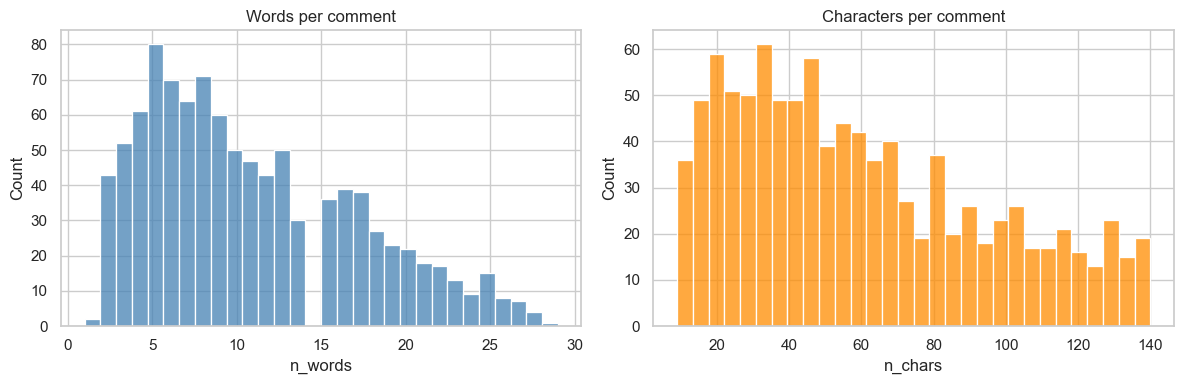

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['n_words'], bins=30, ax=axes[0], color='steelblue')
axes[0].set_title('Words per comment')
axes[0].set_xlabel('n_words')

sns.histplot(df['n_chars'], bins=30, ax=axes[1], color='darkorange')
axes[1].set_title('Characters per comment')
axes[1].set_xlabel('n_chars')
plt.tight_layout()
plt.show()

## Czech-specific Features

In [8]:
CZECH_DIACRITICS = 'áčďéěíňóřšťúůýžÁČĎÉĚÍŇÓŘŠŤÚŮÝŽ'

def has_diacritics(text: str) -> bool:
    return any(ch in CZECH_DIACRITICS for ch in text)

df['has_diacritics'] = df['text'].apply(has_diacritics)
df['has_upper'] = df['text'].apply(lambda s: any(ch.isupper() for ch in s))
df['has_emoji'] = df['text'].apply(lambda s: bool(re2.search(r'\p{Emoji}', s)))
df['has_url'] = df['text'].str.contains(r'http[s]?://|www\.', case=False, regex=True)
df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)

feature_means = (df[['has_diacritics', 'has_upper', 'has_emoji', 'has_url', 'has_mention']]
                  .mean()
                  .sort_values(ascending=False)
                  .to_frame(name='share'))
feature_means['share'] = (feature_means['share'] * 100).round(1)
feature_means

,share
has_diacritics,89.2
has_upper,71.8
has_emoji,16.0
has_url,0.4
has_mention,0.2


## Punctuation & Digit Signals

In [9]:
df['has_question'] = df['text'].str.contains(r'\?')
df['has_exclaim'] = df['text'].str.contains(r'!')
df['has_digits'] = df['text'].str.contains(r'\d')
df['starts_with_dash'] = df['text'].str.startswith('-')

signal_rates = (df[['has_question', 'has_exclaim', 'has_digits', 'starts_with_dash']]
                 .mean()
                 .sort_values(ascending=False)
                 .to_frame(name='share'))
signal_rates['share'] = (signal_rates['share'] * 100).round(1)
signal_rates

,share
has_question,19.6
has_digits,15.5
has_exclaim,11.1
starts_with_dash,0.0


## Frequent Tokens (rough idea of vocabulary overlap)

In [10]:
token_pattern = re2.compile(r'\p{L}+')
counter = Counter()
for text in df['text']:
    counter.update(token_pattern.findall(text.lower()))

top_tokens = counter.most_common(25)
top_tokens

[('to', 342),
 ('a', 294),
 ('je', 216),
 ('se', 214),
 ('na', 186),
 ('d', 150),
 ('v', 129),
 ('tak', 118),
 ('že', 98),
 ('za', 94),
 ('jsem', 91),
 ('ale', 91),
 ('o', 89),
 ('si', 88),
 ('už', 75),
 ('mi', 67),
 ('by', 65),
 ('bych', 64),
 ('s', 59),
 ('já', 57),
 ('mě', 54),
 ('co', 53),
 ('jak', 53),
 ('do', 52),
 ('den', 46)]

## Sample Comments (spot-check formatting)

In [11]:
sample_rows = df.sample(10, random_state=42).reset_index(drop=True)
sample_rows

,text,n_chars,n_words,has_diacritics,has_upper,has_emoji,has_url,has_mention,has_question,has_exclaim,has_digits,starts_with_dash
0,konečně super sleva!! zakoupeno!!,33,4,True,False,False,False,False,False,True,False,False
1,"A né,aby jste mi ten příspěvek hned smazali!To by pak nebyla objektivní diskuze,ale zase jen reklama.",101,16,True,True,False,False,False,False,True,False,False
2,bude ještě někdy funkční? :-DDD,31,5,True,True,False,False,False,True,False,False,False
3,už byla soutěž vyhodnocena? kolik kostiček v bedně bylo?,56,9,True,False,False,False,False,True,False,False,False
4,"jj ten mě baví, 4 lekce už jsou skoro doma ;)",45,11,True,False,True,False,False,False,False,True,False
5,"ale ví že to existuje, ale není to všude no, pokud jsem to dobře pochopila tak nahoře na tom odkazu je vypsané, kde to platí... ;)",130,26,True,False,False,False,False,False,False,False,False
6,"Mňam, vezměte mě hned někdo do mekáče:o)",40,7,True,True,False,False,False,False,False,False,False
7,"T-mobile dělá totéž po celé ČR, gratuluju Pražákům že se dočkali... :)",70,12,True,True,False,False,False,False,False,False,False
8,klidně někdy ho někam hodím a nechybí mi třeba i týden,54,11,True,False,False,False,False,False,False,False,False
9,"Měsíčně máte 125 + 125, že. To stojí kolik ?",44,10,True,True,True,False,False,True,False,True,False
